In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

In [2]:
H = 100
W = 100
h = H-1
w = W-1

n_min = 2
n_max = 6

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.43083576 0.83333333 0.10768034 0.15666667]
 [0.50205093 0.5        0.17623602 0.18536798]
 [0.44986716 0.16666667 0.13288908 0.13288908]]
[0. 0. 2.]


In [3]:
anchor_boxes = np.array([
    [0.5,0.5],
    [0.5,0.25],
    [0.25,0.5],
    [0.25,0.25],
    [0.25,0.125],
    [0.125,0.25],
    [0.125,0.125]
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = (j+0.5)/W
        anchors[i,j,:,1] = (i+0.5)/H
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

W0807 16:28:43.465416 140439781689088 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


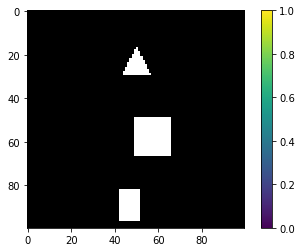

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [8]:
Ntrain = 1000
lr     = 0.01

In [ ]:
x_tf       = tf.placeholder(shape=[1,H,W,3], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=3, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=30, hidden_size=256)

rpn_box, rpn_obj = rpn(x_tf)

list_box = tf.reshape(rpn_box, shape=[-1,4])
list_obj = tf.reshape(rpn_obj, shape=[-1])

print(rpn_box)
print(rpn_obj)
print(list_box)
print(list_obj)

In [7]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    #model.train(x,gt_t,gt_labels,gt_weights)

[0.425 0.825 0.125 0.125]
